In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


630 630
1500
3000
filepaths:  3000    labels:  3000
                                              filepaths labels
0     /content/gdrive/MyDrive/brain_tumor_dataset_ma...     No
1     /content/gdrive/MyDrive/brain_tumor_dataset_ma...     No
2     /content/gdrive/MyDrive/brain_tumor_dataset_ma...     No
3     /content/gdrive/MyDrive/brain_tumor_dataset_ma...     No
4     /content/gdrive/MyDrive/brain_tumor_dataset_ma...     No
...                                                 ...    ...
2995           ./brain_tumor_dataset_main/yes/y1345.jpg    Yes
2996           ./brain_tumor_dataset_main/yes/y1161.jpg    Yes
2997            ./brain_tumor_dataset_main/yes/y113.jpg    Yes
2998             ./brain_tumor_dataset_main/yes/y11.jpg    Yes
2999           ./brain_tumor_dataset_main/yes/y1332.jpg    Yes

[3000 rows x 2 columns]


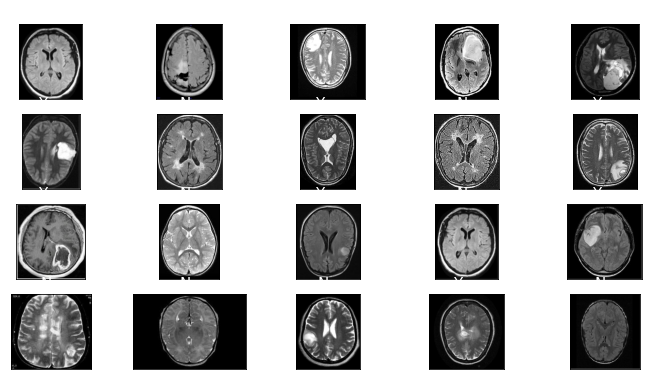

/content/gdrive/MyDrive/brain_tumor_dataset_main/no/no1128.jpg
['./brain_tumor_dataset_main/yes/y712.jpg', './brain_tumor_dataset_main/yes/y973.jpg', '/content/gdrive/MyDrive/brain_tumor_dataset_main/no/no1128.jpg', './brain_tumor_dataset_main/yes/y1281.jpg', '/content/gdrive/MyDrive/brain_tumor_dataset_main/no/no260.jpg', '/content/gdrive/MyDrive/brain_tumor_dataset_main/no/no310.jpg', '/content/gdrive/MyDrive/brain_tumor_dataset_main/no/no1294.jpg', '/content/gdrive/MyDrive/brain_tumor_dataset_main/no/no24.jpg', '/content/gdrive/MyDrive/brain_tumor_dataset_main/no/no446.jpg', './brain_tumor_dataset_main/yes/y859.jpg', '/content/gdrive/MyDrive/brain_tumor_dataset_main/no/no295.jpg', '/content/gdrive/MyDrive/brain_tumor_dataset_main/no/no1489.jpg', './brain_tumor_dataset_main/yes/y1348.jpg', '/content/gdrive/MyDrive/brain_tumor_dataset_main/no/no1055.jpg', '/content/gdrive/MyDrive/brain_tumor_dataset_main/no/no34.jpg', './brain_tumor_dataset_main/yes/y263.jpg', '/content/gdrive/MyDrive

In [ ]:
import os
import PIL
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import adam_v2
from tensorflow import keras
import cv2
Root='/content/gdrive//MyDrive/'
os.chdir(Root)
image = PIL.Image.open("./brain_tumor_dataset_main/no/no0.jpg")


width, height = image.size
print(width,height)
No_tumor = '/content/gdrive/MyDrive/brain_tumor_dataset_main/no'
Yes_tumor = './brain_tumor_dataset_main/yes'
dirlist=[No_tumor, Yes_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
 
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
    print(len(filepaths))    
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(3000,2), columns = ['filepaths', 'labels'])
print(df)
plt.figure(figsize=(12, 8))
for i in  range(20):
    random = np.random.randint(1, len(df))
    plt.subplot(5, 5, i + 1)
    plt.imshow(cv2.imread(df.loc[random, "filepaths"]))
    plt.title(df.loc[random, "labels"], size=15, color="white")
    plt.xticks([])
    plt.yticks([])

plt.show()
train, test = train_test_split(df, train_size=0.95, random_state=1)
train_new, valid = train_test_split(train, train_size=0.90, random_state=1)

print(test.iloc[2]['filepaths'])
print(test["filepaths"].tolist())
testfiles=test["filepaths"].tolist()
testlabels=test["labels"].tolist()


print(f"train set : {train_new.shape}")
print(f"test set : {test.shape}")
print(f"validation set : {valid.shape}")
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

test_gen = test_datagen.flow_from_dataframe(test,target_size = (224,224), x_col = 'filepaths', y_col ='labels',class_mode = 'binary', batch_size = 16, shuffle = False)
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,x_col = 'filepaths', y_col ='labels',target_size = (224,224), batch_size = 32, class_mode = 'binary', shuffle = True)
val_gen = test_datagen.flow_from_dataframe(valid, target_size=(224,224), x_col = 'filepaths', y_col ='labels', class_mode='binary',batch_size= 16, shuffle=True)



In [ ]:
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5",save_best_only=True, verbose = 0) ##val_loss by default
]





model.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 1, 
                    callbacks = [callbacks], verbose = 1)
base_model.trainable =True
model.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(learning_rate= 0.00001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 1, 
                    callbacks = [callbacks], verbose = 1)
model.save('./content/gdrive/MyDrive/Tumor_classifier_model.h5')





94683136/94668760 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable

In [ ]:

############### fine_tuning



In [ ]:
from PIL import Image
model_path = "Tumor_classifier_model.h5"
loaded_model = tf.keras.models.load_model(model_path)
rightcounter=0
TP=0
FP=0
TN=0
FN=0

print("Evaluate on test data")
print(len(testfiles))
for i in range(len(testfiles)):
  image = cv2.imread(testfiles[i])

  image_fromarray = Image.fromarray(image, 'RGB')

  resize_image = image_fromarray.resize((224, 224))
  expand_input = np.expand_dims(resize_image,axis=0)
  input_data = np.array(expand_input)
  input_data = input_data/255

  pred = loaded_model.predict(input_data)
  if pred>=0.5 and testlabels[i]=="Yes":
    rightcounter+=1
    TP+=1
  if pred<0.5 and testlabels[i]=="No":
    rightcounter+=1
    TN+=1
  if pred>=0.5 and testlabels[i]=="No":
    FP+=1
  if pred<0.5 and testlabels[i]=="Yes":
    
    FN+=1 

print(rightcounter/len(testfiles))  
print(TP/(TP+FN)) ##recall
print(TN/(TN+FP))#specificity
print(TP/(TP+FP))##Precision
print(2*TP/(2*TP+FP+FN))##F1 Score     


Evaluate on test data
150
0.74
0.4868421052631579
1.0
1.0
0.6548672566371682


In [11]:
!git init
!git add README.md
!git commit -m "first commit"
!git branch -M master
!git remote add origin https://github.com/RaspberryFahim/Brain-Tumor-Recognition.git
!git push -u origin master

Reinitialized existing Git repository in /content/Brain-Tumor-Recognition/.git/
fatal: pathspec 'README.md' did not match any files

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@7cbb1ef7abc6.(none)')
error: refname refs/heads/master not found
fatal: Branch rename failed
fatal: remote origin already exists.
error: src refspec master does not match any.
error: failed to push some refs to 'https://github.com/RaspberryFahim/Brain-Tumor-Recognition.git'


Initialized empty Git repository in /content/.git/


In [3]:
t

Cloning into 'Brain-Tumor-Recognition'...


# New Section

/content/Brain-Tumor-Recognition


origin	https://github.com/RaspberryFahim/Brain-Tumor-Recognition.git (fetch)
origin	https://github.com/RaspberryFahim/Brain-Tumor-Recognition.git (push)


On branch master

No commits yet

nothing to commit (create/copy files and use "git add" to track)


On branch master

No commits yet

nothing to commit (create/copy files and use "git add" to track)
